In [1]:
%matplotlib widget

import os
import pickle
import glob
import xarray as xr
import dask.array as da
from matplotlib import pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
import numpy as np
from tqdm.auto import tqdm

import themachinethatgoesping.pingprocessing as proc?

# --- simplify creating figures ---
mpl.rcParams['figure.dpi'] = 100
close_plots: bool = True

def create_figure(name, return_ax = True):
    """Helper function to create a figure with a given name that returns the figure and axis
    """
    if close_plots:
        plt.close(name)
    fig = plt.figure(name)
    fig.suptitle = name

    if return_ax:
        return fig, fig.subplots()
    return fig

# --- time axis formating for figures ---
def set_ax_timeformat(ax, timeformat = "%d-%m-%Y %H:%M:%S"):
    if not hasattr(ax, '__iter__'):
        ax = [ax]
    
    for a in ax:
        a.xaxis.set_major_formatter(mdates.DateFormatter(timeformat))
        a.xaxis.set_major_locator(mdates.AutoDateLocator())
        a.tick_params(axis='x', rotation=30)

Object `proc` not found.


## Task3: convert all pkl files to zarr/netcdf
- do this in a new notebook

Reading all .pkl files in a folder

In [2]:
# list .pkl files in ES333 folder

files = []

for r,d,f in os.walk('C:\\Users\\samira.lashkari\\OneDrive - VLIZ\\Bureaublad\\Ping_data\\Processed_Ping\\Processed_Ping/'):
    if 'ES333' in r:
        for file in f:
            if file.endswith('.pkl'):
                    files.append(os.path.join(r,file))

files.sort()

print("Files:", len(files))
files

Files: 0


[]

A function to read all .pkl files in a folder and get its parameter and transform all of them to an xarray data which is compatible with dask. It will save all the xarrays in zarr format in the folder.

In [49]:
def read_pkls_save_as_zarr(folder_path): 

    # Change directory to the specified folder
    os.chdir(folder_path)
    
    # Find all .pkl files in the folder
    pkl_files = glob.glob('*.pkl')

    # Initialize an empty list to store xarray datasets
    datasets = []

    # Iterate over each .pkl file
    for pkl_file in pkl_files:
        # Open the pickle file
        with open(pkl_file, 'rb') as f:
            # Load the data from the pickle file
            echo = pickle.load(f)

            # Getting meta data of each .pkl file
            # list of time coordinates of each ping
            times = echo.get_ping_times_unixtimes()
            times_mdate = echo.get_ping_times_mdates()
            times_datetime = echo.get_ping_times_datetimes()
            # list of depth coordinates of each sample
            depths = echo.get_sample_depths()
            # get image with extent
            image, extent = echo.get_echogram(ping_axis='time', sample_axis='depth')
            # Convert datetime objects to timestamps (seconds since the Unix epoch)
            timestamps = np.array([dt.timestamp() for dt in times_datetime])


            # Convert arrays to dask arrays
            image_dask = da.from_array(image, chunks=(1000, 1000)) 
            depths_dask = da.from_array(depths, chunks=(1000,))  
            times_dask = da.from_array(times, chunks=(1000,)) 
            times_mdate_dask = da.from_array(times_mdate, chunks=(1000,))  
            times_datetime_dask = da.from_array(timestamps, chunks=(1000,))


            # Create xarray dataset with dask arrays
            xr_image = xr.Dataset(
                {
                    "image": (["x", "y"], image_dask),  # Create data variable for the image
                    "depth": (["y"], depths_dask),
                    "times": (["x"], times_dask),
                    "times_mdate": (["x"], times_mdate_dask),
                    "times_datetime": (["x"], times_datetime_dask)
                                  
                }
            )

            # Add attributes
            xr_image.attrs["extent"] = extent
            # Print the dataset
            print(xr_image)

            # Save the xarray dataset as a .zarr file with the same name as the .pkl file
            xr_image.to_zarr(os.path.splitext(pkl_file)[0] + '.zarr')       

            datasets.append(xr_image)

    return(datasets)

In [2]:
folder_path = "C:\\Users\\samira.lashkari\\OneDrive - VLIZ\\Bureaublad\\Ping_data\\Processed_Ping\\Processed_Ping\\ES333-7C_ES"
datasets = read_pkls_save_as_zarr(folder_path)

## Task2: research posibilities
- understand how zarr can open multiple netcdfs, 
    - open multiple files (e.g. multiple netcdf files)
    - what can I do with these files?

In [50]:
# Define the path to the folder containing the Zarr files
folder_path = "C:\\Users\\samira.lashkari\\OneDrive - VLIZ\\Bureaublad\\Ping_data\\Processed_Ping\\Processed_Ping\\ES333-7C_ES"

# List all files in the folder
files = os.listdir(folder_path)

# Filter only the Zarr files
zarr_files = [file for file in files if file.endswith('.zarr')]

# Read each Zarr file using xarray.open_zarr()
datasets = []
for zarr_file in zarr_files:
    file_path = os.path.join(folder_path, zarr_file)
    dataset = xr.open_zarr(file_path)
    datasets.append(dataset)

In [51]:
datasets

[<xarray.Dataset> Size: 356MB
 Dimensions:         (y: 5691, x: 7802)
 Coordinates:
   * x               (x) float64 62kB 1.682e+09 1.682e+09 ... 1.682e+09 1.682e+09
   * y               (y) float64 46kB 0.002969 0.008907 0.01484 ... 33.78 33.79
 Data variables:
     depth           (y) float64 46kB dask.array<chunksize=(1000,), meta=np.ndarray>
     image           (x, y) float64 355MB dask.array<chunksize=(1000, 1000), meta=np.ndarray>
     times           (x) float64 62kB dask.array<chunksize=(1000,), meta=np.ndarray>
     times_datetime  (x) float64 62kB dask.array<chunksize=(1000,), meta=np.ndarray>
     times_mdate     (x) float64 62kB dask.array<chunksize=(1000,), meta=np.ndarray>
 Attributes:
     extent:   [19468.38777919751, 19468.49723051125, 33.79179021917598, 5.216...,
 <xarray.Dataset> Size: 3MB
 Dimensions:         (y: 4836, x: 73)
 Coordinates:
   * x               (x) float64 584B 1.682e+09 1.682e+09 ... 1.682e+09 1.682e+09
   * y               (y) float64 39kB 0.00296

## Task4: take zarr/netcdf files
- plot, against ping number / sample number
- plot against time / depth
    - use plt.imshow with extent
    - use xarray with labels (not extent)

Read all xarray data and plot each against ping number/sample number

FrozenMappingWarningOnValuesAccess({'y': 5691, 'x': 7802})
{'extent': [19468.38777919751, 19468.49723051125, 33.79179021917598, 5.216798234617022e-07]}


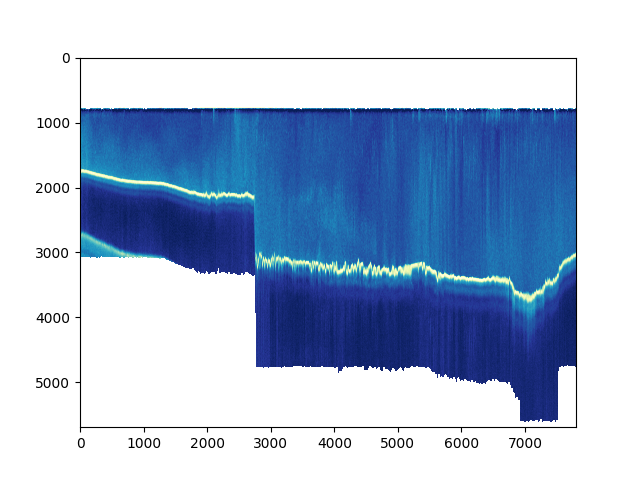

FrozenMappingWarningOnValuesAccess({'y': 4836, 'x': 73})
{'extent': [19468.497231828682, 19468.49841757206, 28.71500554015178, 6.139122984529302e-07]}


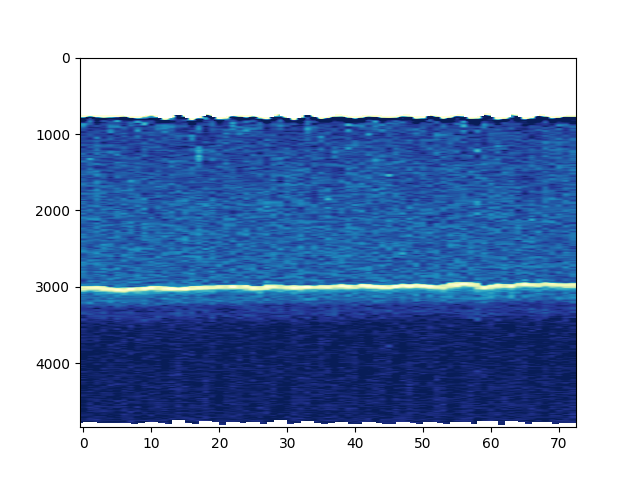

FrozenMappingWarningOnValuesAccess({'y': 6677, 'x': 2797})
{'extent': [19468.498416560717, 19468.53766617133, 39.72360714036156, 1.225654565819613e-06]}


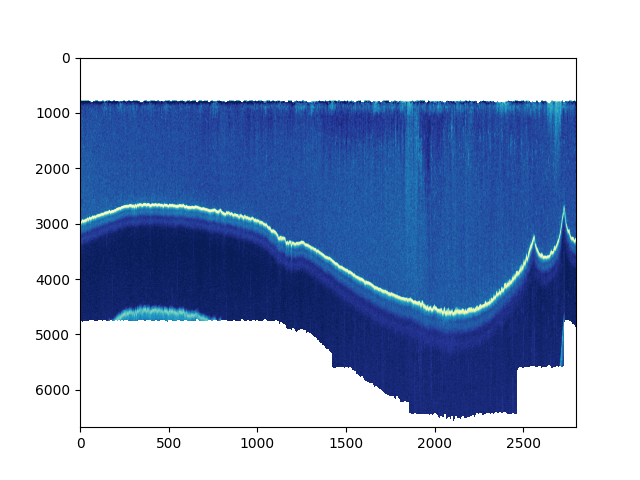

FrozenMappingWarningOnValuesAccess({'y': 4990, 'x': 229})
{'extent': [19468.537669720972, 19468.540882012698, 29.700079738785995, 5.963847602053103e-07]}


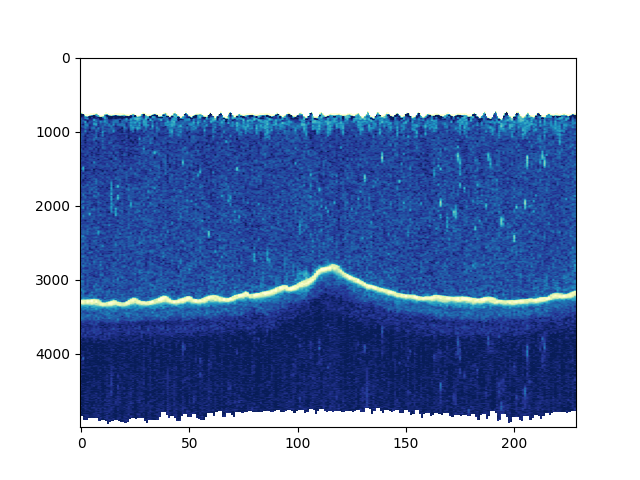

FrozenMappingWarningOnValuesAccess({'y': 7166, 'x': 885})
{'extent': [19468.54089079257, 19468.553307086284, 42.65719253652655, 4.153446971685154e-07]}


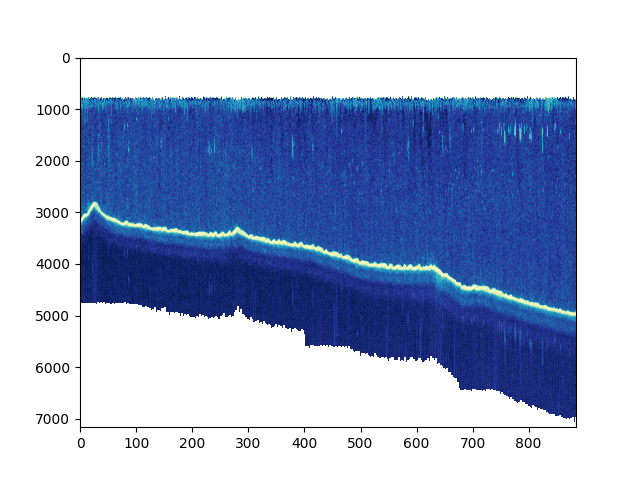

FrozenMappingWarningOnValuesAccess({'y': 8225, 'x': 400})
{'extent': [19468.553315863624, 19468.558928685372, 48.9647420596793, 1.018528564111082e-07]}


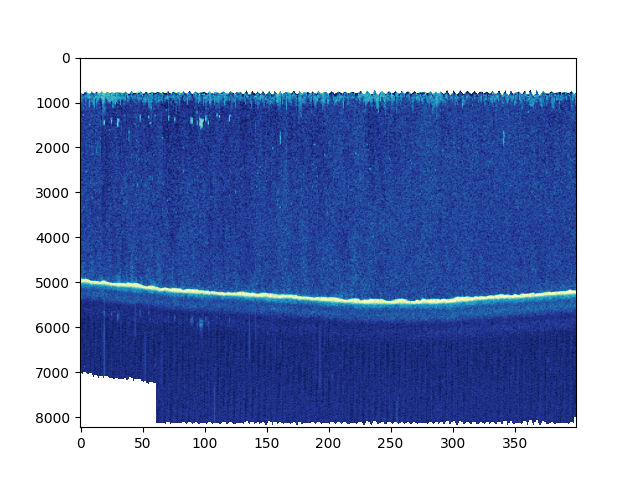

FrozenMappingWarningOnValuesAccess({'y': 9775, 'x': 10001})
{'extent': [19468.558935730023, 19468.69923232773, 58.18979178491584, 3.044971819358283e-07]}


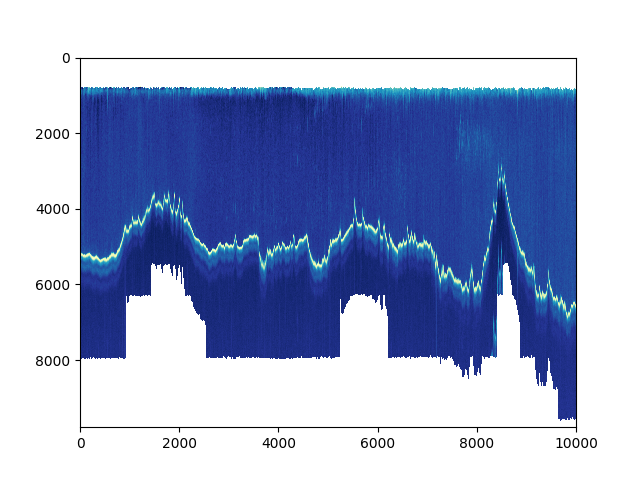

FrozenMappingWarningOnValuesAccess({'y': 9747, 'x': 5143})
{'extent': [19468.69923242058, 19468.771378704583, 58.02311002664945, 3.053719045270631e-07]}


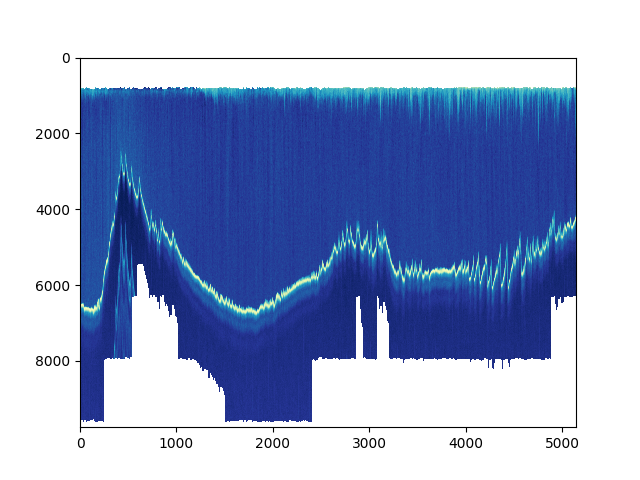

In [52]:
# Iterate over each dataset
for data_xarray in datasets:
    print(data_xarray.dims)
    print(data_xarray.attrs)
    image_values = data_xarray["image"].values
    
    # Create a new figure for each dataset
    fig, ax = plt.subplots()
    ax.imshow(image_values.transpose(), aspect='auto', cmap='YlGnBu_r', vmin=-80, vmax=0)
    
    # Show the plot for the current dataset
    plt.show()  


 plot against time / depth all files together whithout any downsampling

   - use plt.imshow with extent
   - use xarray with labels (not extent)

(58.18979178491584, 1.018528564111082e-07)

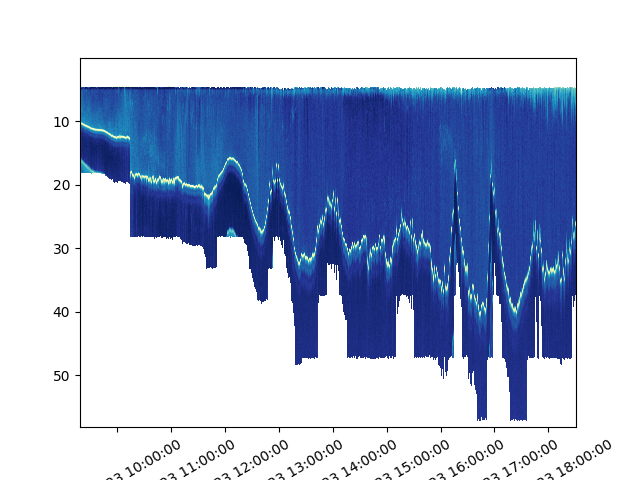

In [53]:
# loop to combine echograms
#No downsampling

fig, ax = create_figure("Echograms (time/depth)")

x=[]
y=[]

for data in datasets:
    
    image = data["image"].values
    extent = data.attrs['extent']
    x.extend(extent[:2])
    y.extend(extent[2:])

    ax.imshow(image.transpose(), aspect='auto', extent=extent, cmap = 'YlGnBu_r', vmin=-80, vmax=0)
    
set_ax_timeformat(ax)
ax.set_xlim(np.nanmin(x), np.nanmax(x))
ax.set_ylim(np.nanmax(y), np.nanmin(y))

 plot against time / depth all files together whit downsampling 4 and then 10 times for each dimension

   - use plt.imshow with extent
   - use xarray with labels (not extent)

(58.18979178491584, 1.018528564111082e-07)

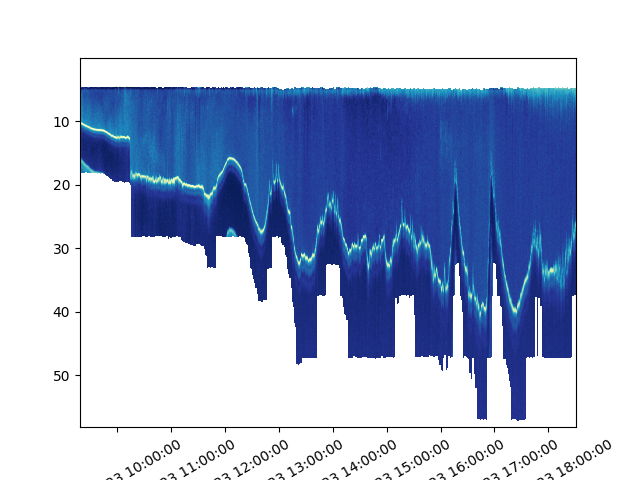

In [54]:
# loop to combine echograms
# downsampling level 4 for depth and time
fig, ax = create_figure("Echograms (time/depth)")

x=[]
y=[]

for data in datasets:
    downsampled_image = data["image"].isel(x=slice(None, None, 4))
    downsampled_image_xy = downsampled_image.isel(y=slice(None, None, 4))
    extent = data.attrs['extent']
    x.extend(extent[:2])
    y.extend(extent[2:])

    ax.imshow(downsampled_image_xy.transpose(), aspect='auto', extent=extent, cmap = 'YlGnBu_r', vmin=-80, vmax=0)
    
set_ax_timeformat(ax)
ax.set_xlim(np.nanmin(x), np.nanmax(x))
ax.set_ylim(np.nanmax(y), np.nanmin(y))

(58.18979178491584, 1.018528564111082e-07)

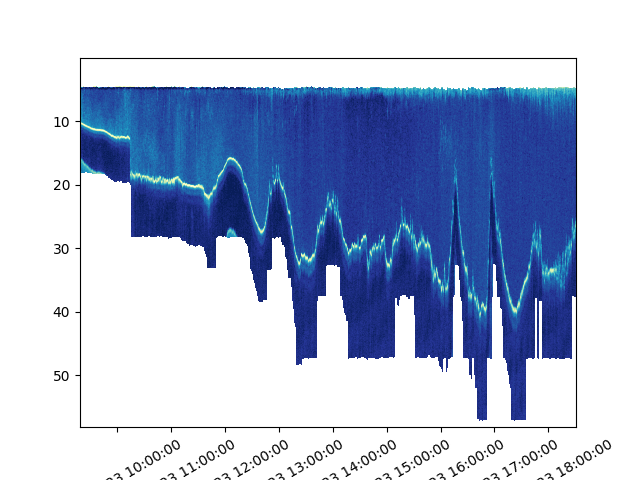

In [55]:
# loop to combine echograms
# downsampling level 10 for depth and time

fig, ax = create_figure("Echograms (time/depth)")

x=[]
y=[]

for data in datasets:
    downsampled_image = data["image"].isel(x=slice(None, None, 10))
    downsampled_image_xy = downsampled_image.isel(y=slice(None, None, 10))
    extent = data.attrs['extent']
    x.extend(extent[:2])
    y.extend(extent[2:])

    ax.imshow(downsampled_image_xy.transpose(), aspect='auto', extent=extent, cmap = 'YlGnBu_r', vmin=-80, vmax=0)
    
set_ax_timeformat(ax)
ax.set_xlim(np.nanmin(x), np.nanmax(x))
ax.set_ylim(np.nanmax(y), np.nanmin(y))

## Task5: handle multiple files
- get time / depth from all dask files
- build function to:
    - extract downsampled dataset for plotting
        - arguments: 
            - dask arrays
            - maximum number of x elements (time axis)
            - maximum number of y elements (depth axis)
        return numpy array with max x and max y dimensions, extent (time,depth)

get_image(dask_arrays, max_x_elements=100000, max_y_elements):
    get time/depth labels from all arrays
    if time elements > max_x_elements:
        create continuous downsampled time elements array

## Task1: modify zarr array after creation (research posibilities)
- is it possiblte to build zarr arrays sequentiall
    - in a loop, assume you don't have the whole image at the beginning
- which possiblities do I have to modify dask array
    - e.g. increase dimension (e.g. x) by adding a ping

In [56]:
def downsapling_image_plot(datasets, downsample_factor):
    # loop to combine echograms

    fig, ax = create_figure("Echograms (time/depth)")

    x=[]
    y=[]

    for data in datasets:
        downsampled_image = data["image"].isel(x=slice(None, None, downsample_factor))
        downsampled_image_xy = downsampled_image.isel(y=slice(None, None, downsample_factor))
        extent = data.attrs['extent']
        x.extend(extent[:2])
        y.extend(extent[2:])

        ax.imshow(downsampled_image_xy.transpose(), aspect='auto', extent=extent, cmap = 'YlGnBu_r', vmin=-80, vmax=0)
        
    set_ax_timeformat(ax)
    ax.set_xlim(np.nanmin(x), np.nanmax(x))
    ax.set_ylim(np.nanmax(y), np.nanmin(y))
    

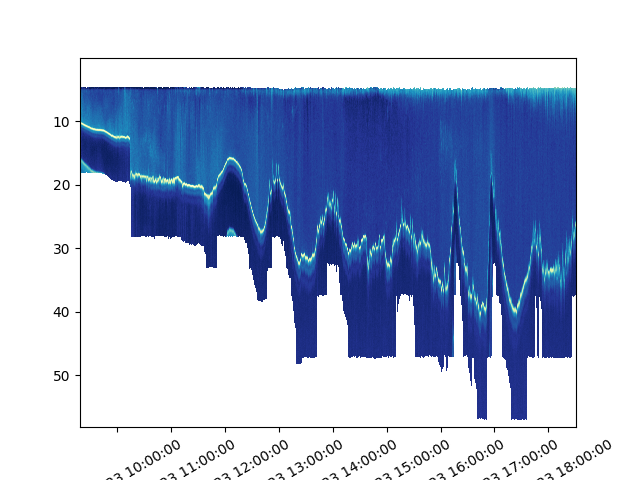

In [60]:
downsapling_image_plot(datasets, downsample_factor = 2)

In [61]:
def get_accumulated_size(datasets):
    accumulated_x_size = 0
    max_y_size = 0
    min_time = np.inf  # Initialize with positive infinity
    max_time = -np.inf  # Initialize with negative infinity

    for da in datasets:
        # Accumulate the size of the x dimension
        accumulated_x_size += da.sizes.get('x', 0)

        # Get the size of the y dimension and update max_y_size if necessary
        y_size = da.sizes.get('y', 0)
        if y_size > max_y_size:
            max_y_size = y_size
            dataset_with_max_y = da
        
        # Update min_time and max_time
        dataset_min_time = np.min(da.times_datetime.values)
        dataset_max_time = np.max(da.times_datetime.values)
        if dataset_min_time < min_time:
            min_time = dataset_min_time
        if dataset_max_time > max_time:
            max_time = dataset_max_time
    
    return accumulated_x_size, max_y_size, min_time, max_time,dataset_with_max_y

get_accumulated_size(datasets)

(27330,
 9775,
 1682068704.728624,
 1682101846.514182,
 <xarray.Dataset> Size: 783MB
 Dimensions:         (y: 9775, x: 10001)
 Coordinates:
   * x               (x) float64 80kB 1.682e+09 1.682e+09 ... 1.682e+09 1.682e+09
   * y               (y) float64 78kB 0.002976 0.008929 0.01488 ... 58.18 58.19
 Data variables:
     depth           (y) float64 78kB dask.array<chunksize=(1000,), meta=np.ndarray>
     image           (x, y) float64 782MB dask.array<chunksize=(1000, 1000), meta=np.ndarray>
     times           (x) float64 80kB dask.array<chunksize=(1000,), meta=np.ndarray>
     times_datetime  (x) float64 80kB dask.array<chunksize=(1000,), meta=np.ndarray>
     times_mdate     (x) float64 80kB dask.array<chunksize=(1000,), meta=np.ndarray>
 Attributes:
     extent:   [19468.558935730023, 19468.69923232773, 58.18979178491584, 3.04...)

In [63]:
def generate_time_steps(min_time, max_time, num_time_steps):
    return np.linspace(min_time, max_time, num=num_time_steps)

def interpolate_and_concatenate_datasets(datasets, dataset_with_max_y):
    interpolated_datasets = []

    for ds in datasets:
        if ds is not dataset_with_max_y:
            # Interpolate to match the y-dimension of the dataset with max y size
            interpolated_ds = ds['image'].interp(y=dataset_with_max_y['image']['y'])
        else:
            interpolated_ds = ds['image']
        interpolated_datasets.append(interpolated_ds)

    # Concatenate all interpolated datasets along the time dimension ('x')
    merged_dataset = xr.concat(interpolated_datasets, dim='x')
    
    return merged_dataset

def get_nearest_timesteps(merged_dataset, time_steps):
    # Select data points that are nearest to the specified time steps
    nearest_data = merged_dataset.sel(x=time_steps, method='nearest')
    return nearest_data

def get_image_with_number_timesteps( datasets, num_time_steps):

    # Get accumulated size, max depth, time range, and dataset with max depth
    accumulated_x_size, max_y_size, min_time, max_time, dataset_with_max_y = get_accumulated_size(datasets)

    # Interpolate and concatenate datasets
    merged_dataset = interpolate_and_concatenate_datasets(datasets, dataset_with_max_y)

    # Generate time steps    
    time_steps = generate_time_steps(min_time, max_time, num_time_steps)

    # Get data with nearest time steps
    nearest_data = get_nearest_timesteps(merged_dataset, time_steps)

    return(nearest_data)   

nearest_data = get_image_with_number_timesteps( datasets, num_time_steps=10000) 
nearest_data

<xarray.DataArray 'image' (x: 10000, y: 9775)> Size: 782MB
dask.array<getitem, shape=(10000, 9775), dtype=float64, chunksize=(366, 1000), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float64 80kB 1.682e+09 1.682e+09 ... 1.682e+09 1.682e+09
  * y        (y) float64 78kB 0.002976 0.008929 0.01488 ... 58.17 58.18 58.19

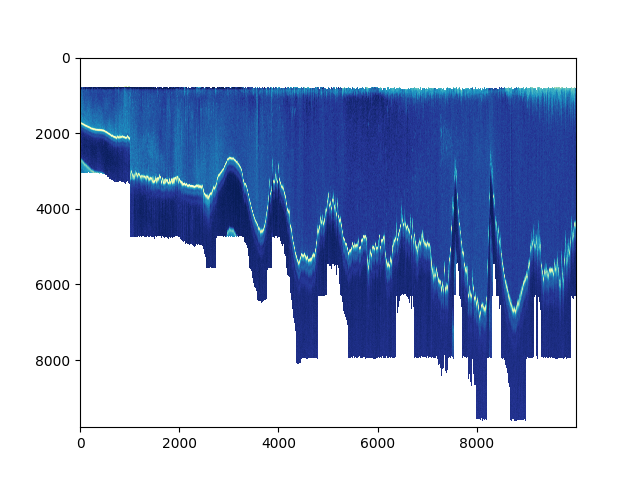

In [64]:
image_values = nearest_data.values
fig, ax = create_figure("Echogram (ping/sample)")
ax.imshow(image_values.transpose(), aspect='auto', cmap = 'YlGnBu_r', vmin = -80, vmax =0)

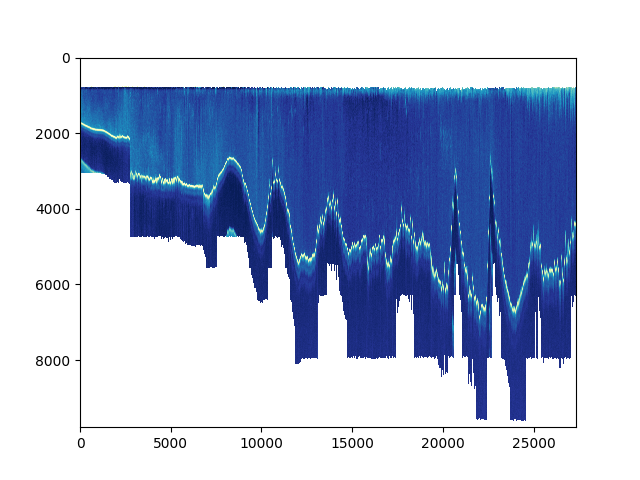

In [65]:
accumulated_x_size, max_y_size, min_time, max_time, dataset_with_max_y = get_accumulated_size(datasets)
merged_dataset = interpolate_and_concatenate_datasets(datasets, dataset_with_max_y)
image_values = merged_dataset.values
fig, ax = create_figure("Echogram (ping/sample)")
ax.imshow(image_values.transpose(), aspect='auto', cmap = 'YlGnBu_r', vmin = -80, vmax =0)